# Sparkify Project Workspace

This is the final project of my Udacity Nanodegree as Data Scientist. Goal of the project is to predict user churn of an online music streaming service using machine learning algorithms. 

Basis of the project is 12 GB dataset containing all information about user interactions with the online streaming service. The data is stored in a AWS Simple Storage Service (S3) bucket in JSON format.
Datasets of such a large scale are challenging to process on a single computer and are therefore referred to as big data. 

I will use Apache Spark to work with the full dataset. Apache Spark is a popular tool for large scale data processing. It allows to efficiently spread data and computations across a network of distributed computers, called clusters. Each cluster has nodes (computers) that do the computations in parallel.
This workspace contains a tiny subset (128MB) of the full dataset available. I will explore the smaller subset with descriptive statistics using Spark before creating a Spark machine learning model based on the full dataset. The full dataset will be processed in Amazon Web Services (AWS) with an Elastic Map Reduce (EMR) cluster of 3 m5.xlarge machines. 

The project is structured following CRISP-DM, the Cross Industry Process for Data Mining. These are the steps:

- [1. Business Understanding](#BU)
- [2. Data Understanding](#DU)
- [3. Prepare Data](#prepare)
- [4. Data Modeling](#modeling)
- [5. Evaluate the Results](#evaluate)
- [6. Deploy](#deploy)

### Load libraries, create Spark session and import data 

In [74]:
# import libraries for Spark Session
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

# import libraries for sql actions
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

# other non-spark libraries

import datetime
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Spark ML libraries

from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler

In [75]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [76]:
# view information about spark configuration
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.driver.port', '62043'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.app.id', 'local-1609413901384'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '192.168.1.75')]

In [77]:
# define path and load data
path = 'data/mini_sparkify_event_data.json'
user_log = spark.read.json(path)

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`.

<a id='BU'></a>
## 1. Business Understanding

Sparkify is a (fictional) music streaming service with a business case similar to Spotify. The service can be used on two levels, free tier or premium tier. Both levels of service generate revenue for Sparkify. The free tier service is financed by advertisement in between the songs, the premium tier contains of a monthly or yearly subscription fee to have an ads free experience. 
At any moment the user can decide to downgrade from paid/premium to free, upgrade from free to paid/premium or to cancel from the service completely.
    
Customer churn is when a customer unsubscribes from a service, ceases to purchase a product or sopts engaging with a brand [[1](https://www.retentionscience.com/blog/why-measuring-your-customer-churn-rate-increases-revenue/)]. In the case of our music streaming service we define churn as `Cancellation Confirmation` events, which happen for both paid and free tier users.

Usually it is more expensive to acquire new customers than retaining existing customers. Statistics vary from industry to industry, but research indicates that it may cost up to 5 times more to acquire a new customer than to keep an existing one [[2](https://www.forbes.com/sites/jiawertz/2018/09/12/dont-spend-5-times-more-attracting-new-customers-nurture-the-existing-ones/?sh=36d7a6225a8e)].

To prevent churn special discounts or other costly measures are offered to customers. These measures usually lower the revenue. The goal is to identify users who are about to churn ahead of time and only target them with marketing campaigns. 
Churn prediction is an important classification use case for streaming services such as Netflix, Spotify or Apple Music. Companies that can predict customers who are about to churn ahead of time can implement a more effective customer retention strategy.

## 2. Data Understanding

Let's look into the available columns of the data subset (128MB) and their meaning:

In [8]:
# check schema of object
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [44]:
user_log.head(n=1)

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [59]:
# show unique possible values of column 'userAgent'
user_log.select('userAgent').dropDuplicates().show(n=5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"|


In [78]:
# show unique possible values of column 'level'
user_log.select('level').dropDuplicates().sort('level').show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



### Clean Dataset
Clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## 3. Prepare Data

## 4. Data Modeling

## 5. Evaluate the Results

## 6. Deploy

In [53]:
# show unique possible values of column 'status'
user_log.select('status').dropDuplicates().sort('status').show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [51]:
# show unique possible values of column 'method'
user_log.select('method').dropDuplicates().sort('method').show()

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



In [61]:
# show unique possible values of column 'location'
user_log.select('location').dropDuplicates().sort('location').show(n=8, truncate=False)

+---------------------------------+
|location                         |
+---------------------------------+
|null                             |
|Albany, OR                       |
|Albany-Schenectady-Troy, NY      |
|Alexandria, LA                   |
|Allentown-Bethlehem-Easton, PA-NJ|
|Anchorage, AK                    |
|Atlanta-Sandy Springs-Roswell, GA|
|Atlantic City-Hammonton, NJ      |
+---------------------------------+
only showing top 8 rows



In [62]:
# show unique possible values of column 'length'
user_log.select('length').dropDuplicates().sort('length').show(n=6)

+-------+
| length|
+-------+
|   null|
|0.78322|
|2.16771|
|4.04853|
| 4.8322|
| 6.3473|
+-------+
only showing top 6 rows



In [46]:
# show unique possible values of column 'gender'
user_log.select('gender').dropDuplicates().sort('gender').show()

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+



In [45]:
# show unique possible values of column 'auth'
user_log.select('auth').dropDuplicates().sort('auth').show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [9]:
# show unique possible values of column 'page'
user_log.select('page').dropDuplicates().sort('page').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [10]:
# count rows 
user_log.count()

286500

### Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [12]:
# drop any record with NANs in user ID OR session ID and save to new object
user_log_valid = user_log.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [13]:
# check amount of  records
user_log_valid.count()

286500

In [63]:
# show unique user IDs
user_log.select("userId").dropDuplicates().sort("userId").show(n=8)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
+------+
only showing top 8 rows



In [15]:
# drop empty user IDs
user_log_valid = user_log_valid.filter(user_log_valid['userId'] != '')

In [16]:
# check if now less than 286500 records
user_log_valid.count()

278154

### Define Churn

Create a column `Churn` to use as the label for model. Using the `Cancellation Confirmation` events to define  churn, which happen for both paid and free users. Additionally look into the `Downgrade` events.

In [29]:
# show records where downgrade was submitted (churn)
user_log_valid.filter("page = 'Cancellation Confirmation'").show(n=5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [31]:
# Find users who had event 'Cancellation Confirmation'
user_log_valid.select('userID').where(user_log.page == 'Cancellation Confirmation').show(n=8)

+------+
|userID|
+------+
|    18|
|    32|
|   125|
|   105|
|    17|
|   143|
|   101|
|   129|
+------+
only showing top 8 rows



In [32]:
# look at example with event 'Cancellation Confirmation' (without most common NextSong event)
user_log_valid.select(['userId', 'firstname', 'page', 'level', 'song']).where(
    (user_log.userId == '101') & (user_log.page != 'NextSong')).collect()


[Row(userId='101', firstname='Alex', page='Home', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Help', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Add Friend', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Home', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Roll Advert', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Roll Advert', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Thumbs Up', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Roll Advert', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Roll Advert', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Thumbs Up', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Roll Advert', level='free', song=None),
 Row(userId='101', firstname='Alex', page='Home', level='free', song=None),
 Row(userId='101', firstname='Alex', 

In [39]:
# user defined function to flag the events page=submit 'Cancellation Confirmation' with extra column
flag_cancellation_event = udf(
    lambda cancellation_event: 1 if cancellation_event == 'Cancellation Confirmation' else 0, IntegerType())

In [40]:
# create extrac column 'Cancellation Confirmation'
user_log_valid = user_log_valid.withColumn('cancellation_event', flag_cancellation_event('page'))

In [41]:
# check if column 'cancellation_event' existst
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', cancellation_event=0)

In [68]:
# create window function and group by user ID orderd after reverse time, take into account previous rows
# -> Window.unboundedPreceding, but now rows after ->0
windowval_cancellation = Window.partitionBy('userId').orderBy(asc('ts')).rangeBetween(Window.unboundedPreceding, 0)

In [69]:
# create column where all events before downgrade have phase=1 and all events after have events=0
user_log_valid = user_log_valid.withColumn(
    'cancelled_phase', Fsum('cancellation_event').over(windowval_cancellation))

In [73]:
user_log_valid.select([
    'userId', 'firstname', 'ts', 'page', 'level', 'cancellation_event', 'cancelled_phase']).where(
    (user_log.userId == '101') & (user_log.page != 'NextSong')).show(n=600)

+------+---------+-------------+--------------------+-----+------------------+---------------+
|userId|firstname|           ts|                page|level|cancellation_event|cancelled_phase|
+------+---------+-------------+--------------------+-----+------------------+---------------+
|   101|     Alex|1538358605000|                Home| free|                 0|              0|
|   101|     Alex|1538359923000|                Help| free|                 0|              0|
|   101|     Alex|1538361194000|          Add Friend| free|                 0|              0|
|   101|     Alex|1538361487000|                Home| free|                 0|              0|
|   101|     Alex|1538362584000|         Roll Advert| free|                 0|              0|
|   101|     Alex|1538363536000|         Roll Advert| free|                 0|              0|
|   101|     Alex|1538363885000|           Thumbs Up| free|                 0|              0|
|   101|     Alex|1538364596000|         Roll Adve

### Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [25]:
# show records where downgrade was submitted (churn)
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|  11|
|  null|Logged In|   Calvin|     M|           17| Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38| 

In [26]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "30").collect()

[Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Rockpools'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Time For Miracles'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Harder Better Faster Stronger'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Passengers (Old Album Version)'),
 Row(userId='30', firstname='Colin', page='Add to Playlist', level='paid', song=None),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Fuck Kitty'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Jade'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='So-Called Friends'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Represent'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Here I Am'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Reb

In [27]:
# user defined function to flag the events page=submit downgrade with extra column
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [28]:
# create extrac column "downgraded"
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [29]:
# check if column existst
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0', downgraded=0)

In [30]:
# create window function and group by user ID orderd after reverse time, take into account previous rows
# -> Window.unboundedPreceding, but now rows after ->0
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [31]:
# create column where all events before downgrade have phase=1 and all events after have events=0
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [32]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase", "downgraded"]).where(user_log.userId == "30").sort("ts").collect()

[Row(userId='30', firstname='Colin', ts=1538352117000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538352394000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538352676000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538352899000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538352905000, page='Add to Playlist', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538353084000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538353218000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538353441000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538353687000, page='NextSong', level='paid', phase=1, downgraded=0),
 Ro

### Calculating Statistics by Hour

In [ ]:
# How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

# TODO: filter out 0 sum and max sum to get more exact answer

function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = user_log.filter((user_log.page == 'NextSong') | (user_log.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

In [ ]:
# How many songs were played from the most played artist?

user_log.filter(user_log.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(1)

In [ ]:
# How many female users do we have in the data set?

user_log.filter(user_log.gender == 'F').select('userId', 'gender').dropDuplicates().count()

In [ ]:
# Which page did user id "" (empty string) NOT visit?

# filter for users with blank user id
blank_pages = user_log.filter(user_log.userId == '').select(col('page').alias('blank_pages')).dropDuplicates()

# get a list of possible pages that could be visited
all_pages = user_log.select('page').dropDuplicates()

# find values in all_pages that are not in blank_pages
# these are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)

### Explore Data
Perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. Start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [13]:
# create user defined function to convert the ts column into hour format
get_hour = udf(lambda timestamp: datetime.datetime.fromtimestamp(timestamp / 1000.0). hour)

In [14]:
# create new column "hour" by applying udf get_hour
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [15]:
# check if hour column present in first record
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0')

In [16]:
# take only amount of action "NextSong" and group it by hour of day
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(
    user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [17]:
# show resulting table
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [18]:
# convert spark object ot pandas dataframe
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

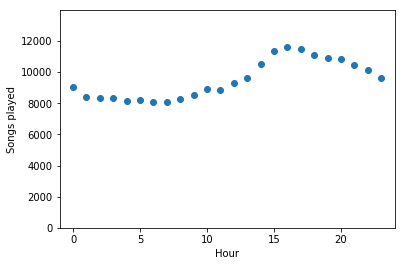

In [19]:
# plot the amount of songs played over hours of day
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.